In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from LSN import *
from models import dp_loss as dpl
from models import dp_utils as dpu

import matplotlib.pyplot as plt

## Paths

In [2]:
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"
img_dir = f"{data_dir}imaging/ukbb_test_subject/"
img_subdirs = ["ses-2/non-bids/T1/","ses-2/non-bids/T1/"]
metadata_csv = f"{data_dir}tabular/ukbb_test_subject_metadata.csv"
sfcn_ckpt = "models/run_20190719_00_epoch_best_mae.p"


## Data-loaders

In [3]:
batch_size = 1

ukbb_dataset = UKBBDataset(img_dir, img_subdirs, metadata_csv)
train_dataloader = DataLoader(ukbb_dataset, batch_size=batch_size, shuffle=True)

## TwinSFCN

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = twinSFCN() # alternative toy model: LSN()

model = torch.nn.DataParallel(model)

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    
model.load_state_dict(torch.load(sfcn_ckpt, map_location=torch.device('cpu')))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Train model 

In [5]:
num_epochs = 10

loss_list = []
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    print("Starting epoch " + str(epoch+1))
    for inputs, outputs in train_dataloader:
        img1 = inputs[0]
        img2 = inputs[1]
        age_at_ses2 = outputs[0]
        age_at_ses3 = outputs[1]

        # Forward
        img1 = img1.to(device)
        img2 = img2.to(device)
        age_at_ses2 = age_at_ses2.to(device)
        age_at_ses3 = age_at_ses3.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(img1, img2)

        loss = dpl.twin_KLDivLoss(preds[0][0],preds[1][0],age_at_ses2,age_at_ses3) #criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        loss_list.append(loss.item())
    
    epoch_loss = running_loss/len(train_dataloader)
    print(f"epoch loss: {epoch_loss:3.2f}")

Starting epoch 1
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 162.82
Starting epoch 2
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 130.97
Starting epoch 3
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 144.40
Starting epoch 4
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 110.25
Starting epoch 5
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
epoch loss: 134.35
Starting epoch 6
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
epoch loss: 136.08
Starting epoch 7
(1, 160, 192, 160), (1, 160, 192, 160), (70.0, 72.0)
(1, 160, 192, 160), (1, 160, 192, 160), (53.0, 55.0)
epoch loss: 113.17
Starti

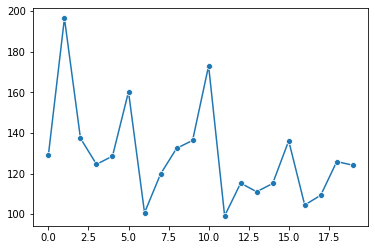

In [7]:
sns.lineplot(x=range(20),y=loss_list,marker='o')